In [1]:
pip install tensorflow==1.14

In [2]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Отрисовка графиков

In [0]:
def gr(X, Y, outputs, batch_size):
    for j in range(batch_size):
        plt.figure(figsize=(12, 3))
        
        for k in range(output_dim):
            past = X[:,j,k]
            expected = Y[:,j,k]
            pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" #if k==0 else "_nolegend_"
        label2 = "True future values" #if k==0 else "_nolegend_"
        label3 = "Predictions" #if k==0 else "_nolegend_"
    
        plt.plot(range(len(past)), past , "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected , "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred , "o--y", label=label3)
    
        plt.legend(loc='best')
        plt.title("Predictions v.s. true values")
        plt.show()

## Функция сбора статистики

In [0]:
def variable_summaries(var): 
    with tf.name_scope('summaries'): 
        mean = tf.reduce_mean(var) 
        tf.summary.scalar('mean', mean) 
        
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean))) 
            
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var)) 
        tf.summary.scalar('min', tf.reduce_min(var)) 
        tf.summary.histogram('histogram', var)

## Функция генерации данных

In [0]:
def generate_x_y_data_v1(isTrain, batch_size):
    seq_length = 10
    
    batch_x = []
    batch_y = []
    for _ in range(batch_size): 
        # Одна итерация цикла генерирует 1 пакет данных 
        rand = random.random() * 2 * math.pi
        
        # Генерируем набор данных по заданному закону
        # генерирует набор точек, равномерно распредленных по заданному интервалу 
        # (границы интервала смещены на случайную величину)
        sig1 = np.sin(np.linspace(0.0 * math.pi + rand , 3.0 * math.pi + rand , seq_length * 2))
        sig2 = np.cos(np.linspace(0.0 * math.pi + rand , 3.0 * math.pi + rand , seq_length * 2))
        
        # первую половину сигналов берем на обучающую выборку, вторую - на контрольную
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x2 = sig2[:seq_length]
        y2 = sig2[seq_length:]
        
        x_ = np.array([x1, x2])
        y_ = np.array([y1, y2])
        x_, y_ = x_.T, y_.T
    
        batch_x.append(x_)
        batch_y.append(y_)
    
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y) 
    # размерность: (batch_size , seq_length , output_dim)
    # транспонируем, чтобы привести к нужной размерности
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2)) 
    # размерность: (seq_length , batch_size , output_dim)
    
    return batch_x , batch_y

## Настройка гиперпараметров

In [6]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

tf.reset_default_graph()
# интерактивная сессия
sess = tf.InteractiveSession()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:

# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = generate_x_y_data_v1(isTrain=True , batch_size=3)

# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 40
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 20
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 2

# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.001
# Количество итераций по обучающей выборке 
nb_iters = 1500
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.95
momentum = 0.1
# Коэффициент L2 регуляризации
lambda_l2_reg = 1e-14

## Описание графа

In [8]:
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
            for t in range(seq_length)
    ]

    expected_sparse_output = [
        tf.placeholder(tf.float32 , shape=(None , output_dim), name="expected_sparse_output_".format(t))
            for t in range(seq_length)
    ]
    
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32 , name="GO") ] + enc_inp[:-1]
    
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    w_in = tf.Variable(tf.random_normal([input_dim , hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    variable_summaries(w_in)
    variable_summaries(b_in)
    variable_summaries(w_out)
    variable_summaries(b_out)

    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )

    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out) + b_out) for i in dec_outputs]

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Описание функции потери


In [9]:
output_scale_factor = tf.Variable(1.0 , name ="Output_ScaleFactor")
reshaped_outputs = [ output_scale_factor *( tf. matmul (i, w_out ) + b_out ) for i in dec_outputs]
with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

    # слагаемое, отвечающее за L2 регуляризацию
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

    loss = output_loss  + lambda_l2_reg * reg_loss
    #tf.summary.scalar('loss', loss)
    
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('lab5' + '/train', graph=tf.get_default_graph())
# Шаг обучения, который оптимизирует веса в соответствии с переданным минипакетом-примеров
def train_batch(batch_size):
    X, Y = generate_x_y_data_v1(isTrain=True , batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))} 
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    #  запускаем сессию. При этом рассчитываются тензоры, указанные в первом параметре, 
    # а значения для них берутся из второго параметра
    _, loss_t = sess.run([train_op , loss], feed_dict)
    
    return loss_t

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Тестовый прогон. Веса не обновляются благодаря тому, что переменная train_op не передается в sess.run
def test_batch(batch_size, graph=False): 
    X, Y = generate_x_y_data_v1(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    outputs, loss_t, summ = sess.run([reshaped_outputs, loss, merged], feed_dict)
    
    outputs = np.array(outputs)
    if graph==True:
        gr(X, Y, outputs, batch_size)
    
    return loss_t, summ

## Обчение модели

Step 0/1500, train loss: 399.58905029296875, 	TEST loss: 315.69500732421875
Step 100/1500, train loss: 0.45104649662971497, 	TEST loss: 0.5650931596755981
Step 200/1500, train loss: 0.4277403652667999, 	TEST loss: 0.6213181018829346
Step 300/1500, train loss: 0.6972335577011108, 	TEST loss: 0.5928292870521545
Step 400/1500, train loss: 0.09511750191450119, 	TEST loss: 0.12446720153093338
Step 500/1500, train loss: 0.8414625525474548, 	TEST loss: 0.7839953899383545
Step 600/1500, train loss: 0.06972821801900864, 	TEST loss: 0.11182419955730438
Step 700/1500, train loss: 0.3685685396194458, 	TEST loss: 0.3547897934913635
Step 800/1500, train loss: 0.20790152251720428, 	TEST loss: 0.1486162543296814
Step 900/1500, train loss: 0.06917741149663925, 	TEST loss: 0.04984629154205322
Step 1000/1500, train loss: 0.8158416748046875, 	TEST loss: 0.3869292140007019
Step 1100/1500, train loss: 0.4972650706768036, 	TEST loss: 0.38982197642326355
Step 1200/1500, train loss: 0.050588179379701614, 	TEST

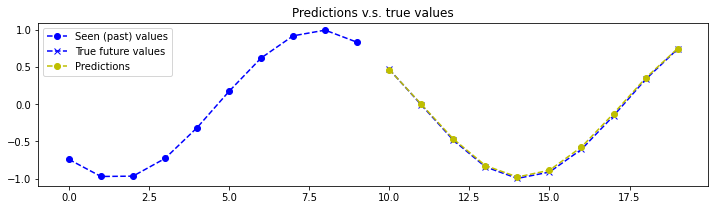

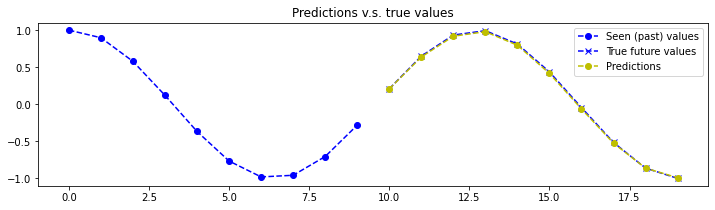

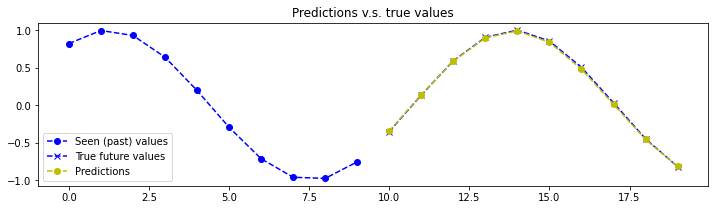

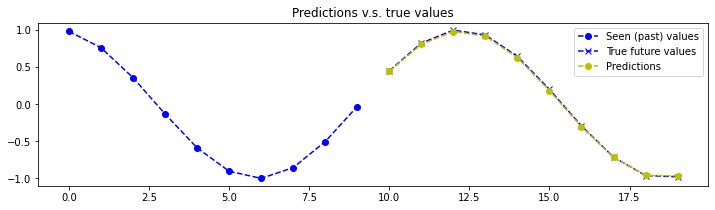

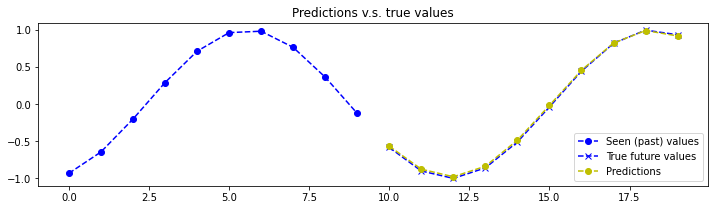

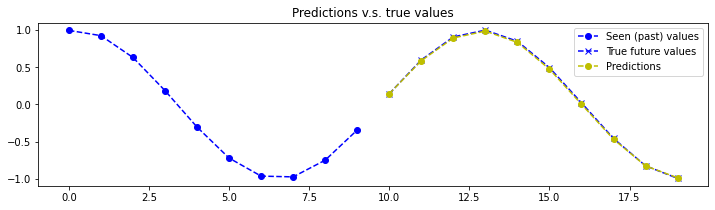

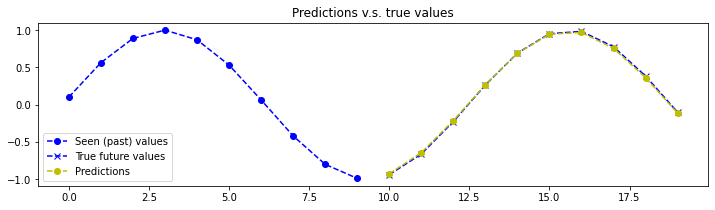

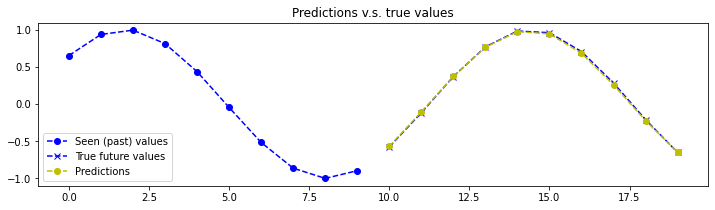

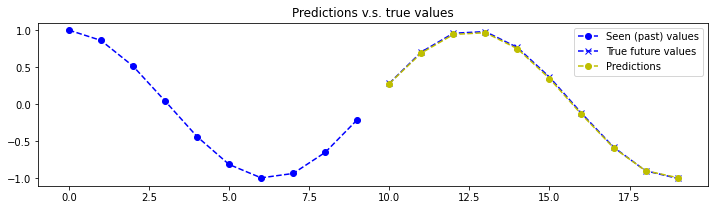

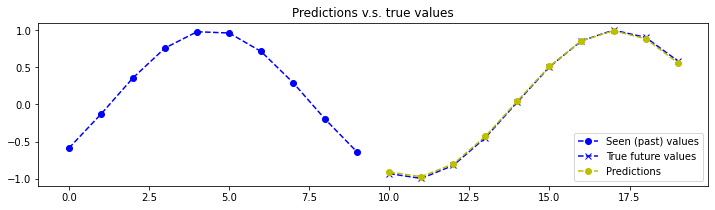

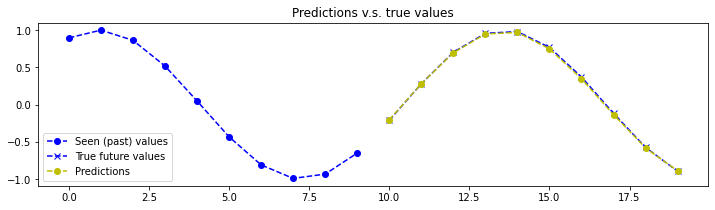

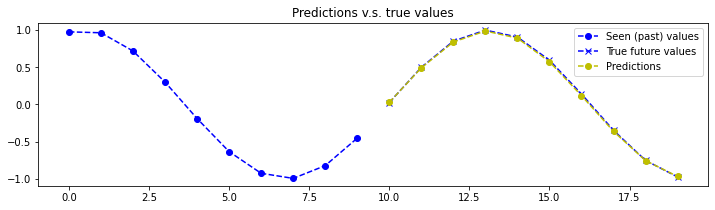

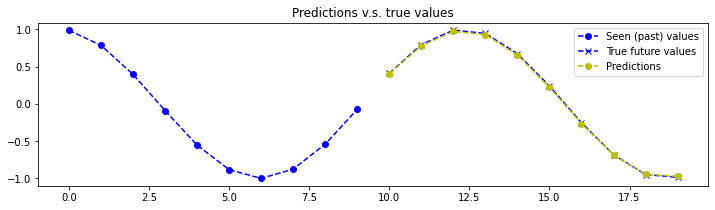

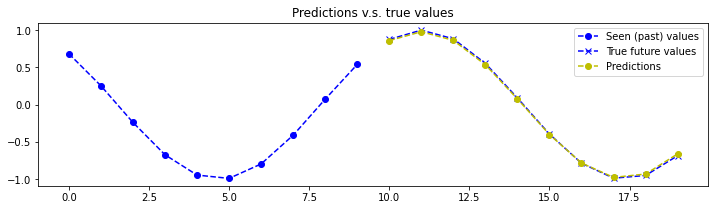

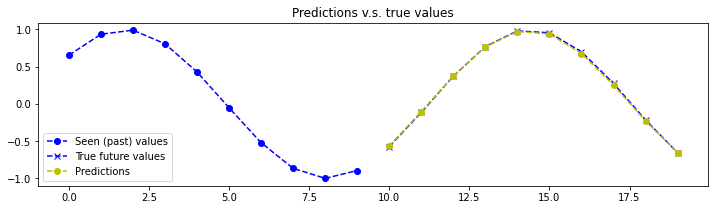

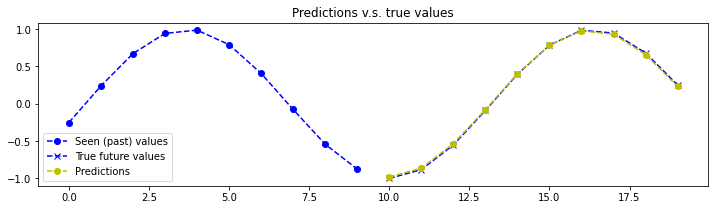

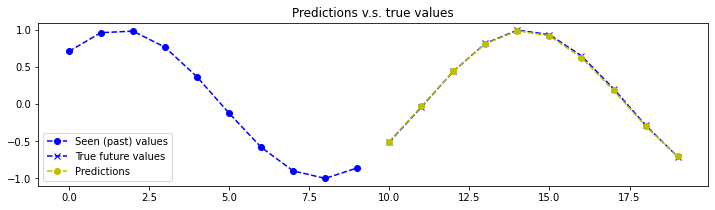

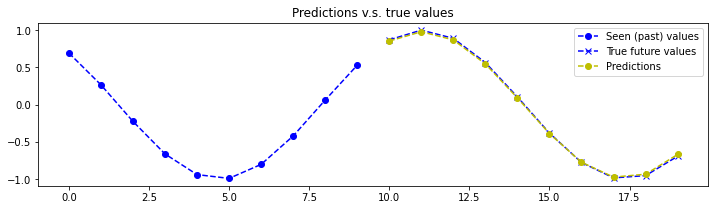

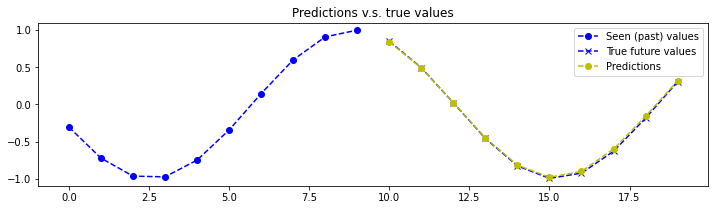

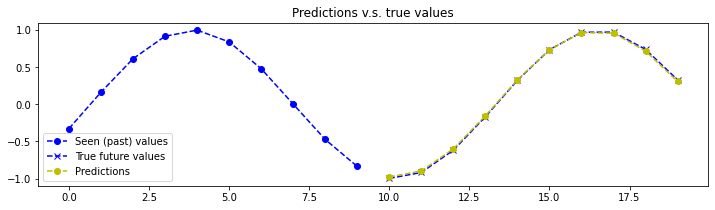

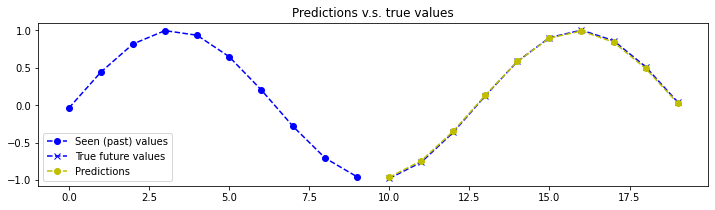

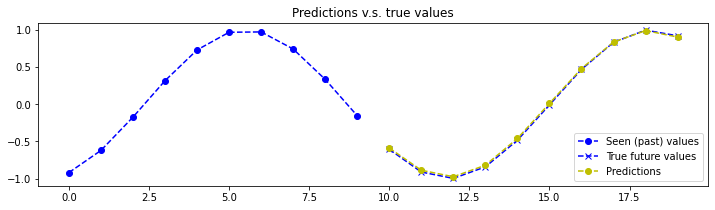

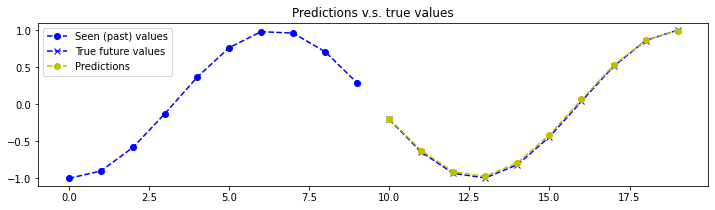

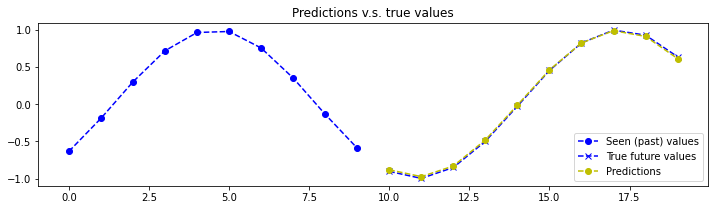

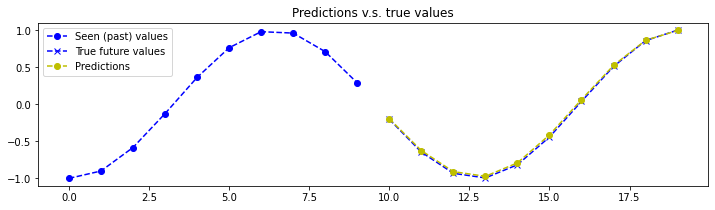

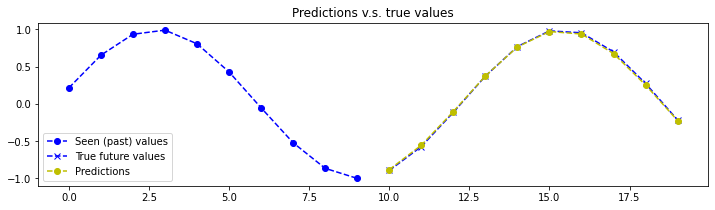

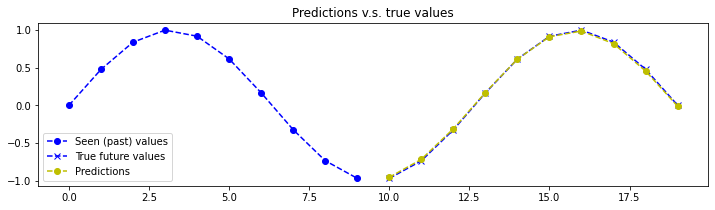

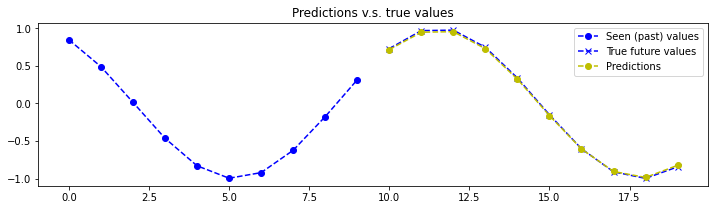

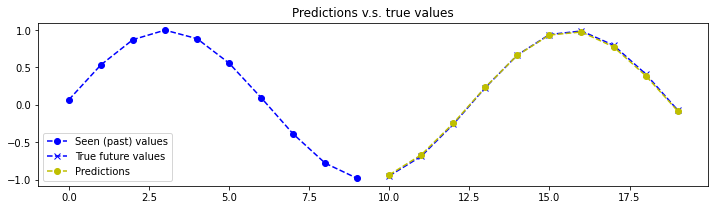

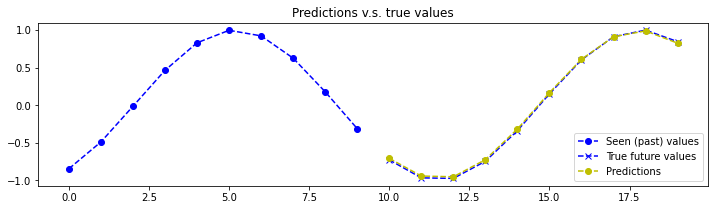

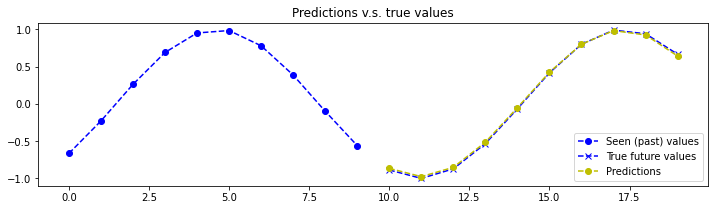

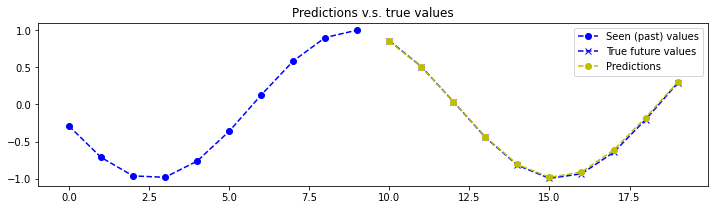

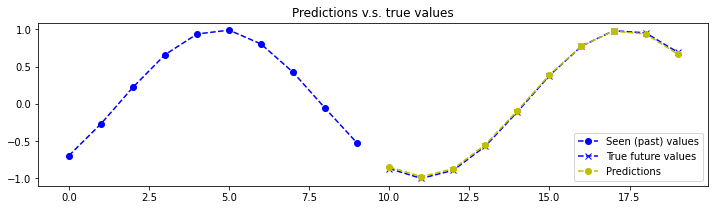

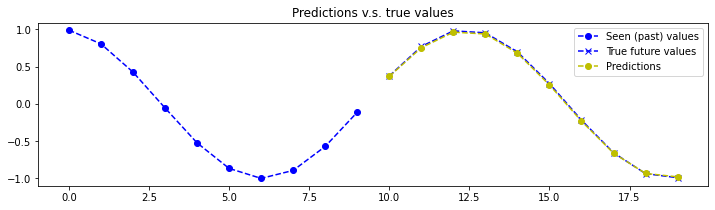

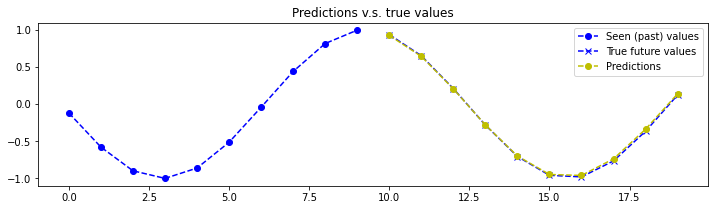

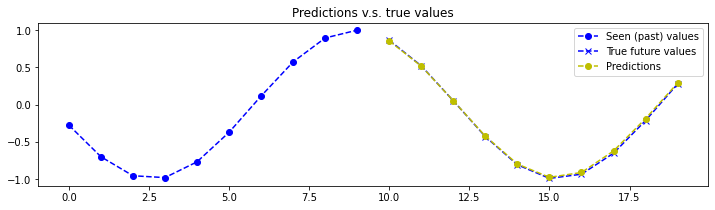

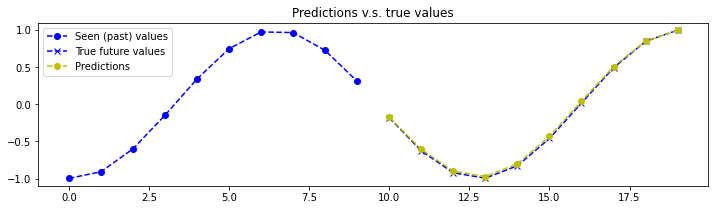

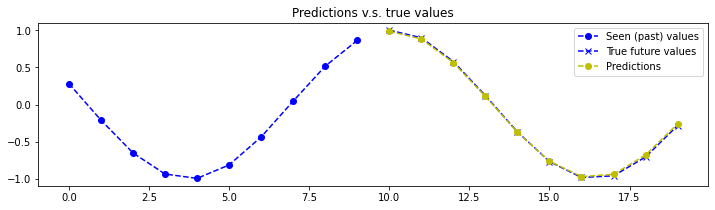

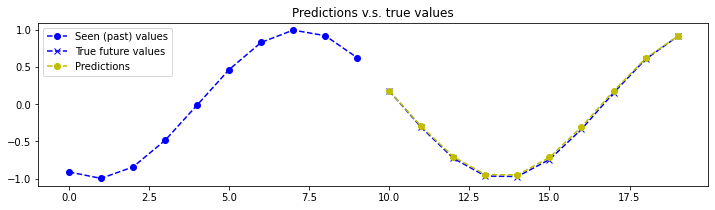

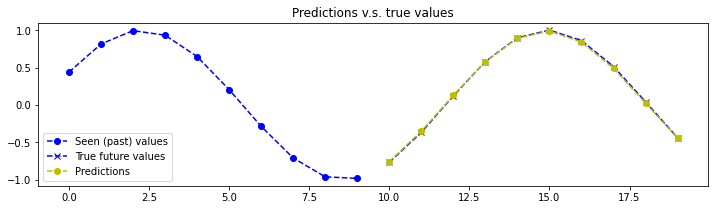

Step 1500/1500, train loss: 0.1442936360836029, 	TEST loss: 0.1476127654314041
Fin. train loss: 0.1442936360836029, 	TEST loss: 0.1476127654314041


In [11]:
train_losses = []
test_losses = []
sess.run(tf.global_variables_initializer())

#nb_iters - количество шагов для обучения. После каждых 10 шагов проверяется ошибка на тестовой выборке



for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)

    if t % 100 == 0:
        test_loss, summ = test_batch(batch_size, t==nb_iters)
        test_losses.append(test_loss)
        train_writer.add_summary(summ, t)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters , train_loss , test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss , test_loss))

## Функция потери во время обучения

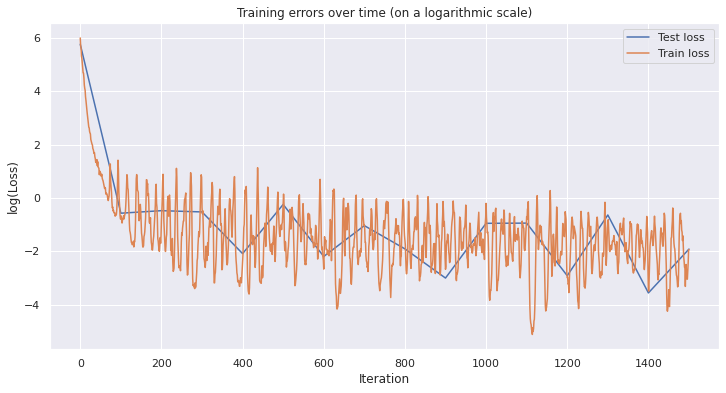

In [14]:
import seaborn as sns
sns.set()

plt.figure(figsize=(12, 6))
plt.plot( 
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss" 
)
plt.plot( 
    np.log(train_losses), 
    label="Train loss" 
)
plt.title("Training errors over time (on a logarithmic scale)") 
plt.xlabel('Iteration')
plt.ylabel('log(Loss)') 
plt.legend(loc='best') 
plt.show()

 Let 's visualize 1 predictions with our signals :


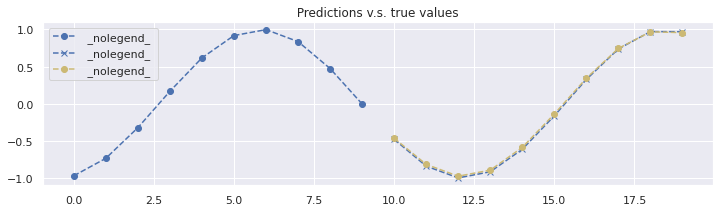

In [15]:
nb_predictions = 1
print (" Let 's visualize {} predictions with our signals :". format (nb_predictions ))
X, Y = generate_x_y_data_v1( isTrain =False , batch_size = nb_predictions )
feed_dict = { enc_inp [t]: X[t] for t in range ( seq_length )}
outputs = np.array( sess.run([ reshaped_outputs ], feed_dict )[0])
# выводим предсказания по каждому пакету
for j in range ( nb_predictions ):
    plt.figure( figsize =(12 , 3))
    for k in range ( output_dim ):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs [:,j,k]
    label1 = " Seen ( past ) values " if k ==0 else " _nolegend_ "
    label2 = " True future values " if k ==0 else " _nolegend_ "
    label3 = " Predictions " if k ==0 else " _nolegend_ "
    plt.plot(range(len(past)), past , "o--b", label = label1 )
    plt.plot(range(len(past),len(expected)+len(past)), expected, "x--b", label = label2)
    plt.plot(range(len(past),len(pred) + len (past)), pred , "o--y", label = label3 )
    plt.legend( loc ='best')
    plt.title(" Predictions v.s. true values ")
    plt.show()